In [1]:
##Summary:
#Total proteins in Biogrid DB (only human-human interaction):                                                16,109
#Total number of unique interactions in Biogrid DB (only human-human interaction and no self-interactions): 219,216
#Total number of interactions in Biogrid DB (only human-human interaction and no self-interactions):        301,448
#Max possible interactions between 16,109 proteins (excluding self interactions):                       129,741,886
#Number of elements in adjacency matrix:                                                                259,499,881

In [2]:
from __future__ import print_function
from __future__ import division

import scipy.spatial
import numpy as np

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics

from time import time
import sys

import copy

In [3]:
t1 = time()

np.random.seed(100)
K = 10
Kmax = 11
dimen = 4

# Read Biogrid data into pandas dataframe
df = pd.read_table("~/work/BIOGRID-ORGANISM-Homo_sapiens-3.4.147.mitab.txt", engine="c")

# Rename first two columns of dataframe
df = df.rename(columns={'#ID Interactor A': 'ID Interactor A'})
df['ID Interactor A'] = df['ID Interactor A'].map(lambda x: x.lstrip('entrez gene/locuslink:'))
df['ID Interactor B'] = df['ID Interactor B'].map(lambda x: x.lstrip('entrez gene/locuslink:'))


# Remove non-human ppi from the dataframe
df = df[df['Taxid Interactor A'].isin(['taxid:9606'])]
df = df[df['Taxid Interactor B'].isin(['taxid:9606'])]

# Remove self interactions
df = df[df['ID Interactor A'] != df['ID Interactor B']]

# Create networkx graph from dataframe (single edge)
G = nx.from_pandas_dataframe(df, 'ID Interactor A', 'ID Interactor B', create_using=nx.Graph())

# Determine total number of proteins in the network
N = G.number_of_nodes()

# Calculate shortest pathlengths dictionary in the graph up to a threshold using networkx
p = nx.all_pairs_shortest_path_length(G,K)
t2 = time()

print("Start until shortest pathlengths:",t2-t1)

Start until shortest pathlengths: 1343.614027261734


In [4]:
# Reformat path lengths to array
dist_df_orig = pd.DataFrame.from_dict(p)
dist_df = dist_df_orig.replace(0,2)
dist_df = dist_df.fillna(0)-Kmax
dist_df[dist_df == -Kmax] = 0
dist_mat = dist_df.values

sum = np.expand_dims(np.sum(dist_mat,1),1)
sumsum = np.sum(dist_mat)

vdiff = np.ones((dimen,1))
vdiffmax = 1
count = 0

v = []
vnew = []
vdiff = []
Av = []
mv = np.zeros(dimen)
lam = np.zeros(dimen)
xvals = np.zeros((N,dimen))

for i in range(dimen):
	v.append(np.random.randn(N,1))
	vnew.append(np.zeros((N,1)))
	vdiff.append(np.zeros((N,1)))
	Av.append(np.zeros((N,1)))

t3=time()

print("Shortest pathlength up to while loop:", t3-t2)

while vdiffmax > 0.001:

	for i in range(dimen):
		mv[i] = np.mean(v[i])
		vnew[i] = -0.5*(np.dot(dist_mat,v[i]) - np.multiply(mv[i],sum) + (mv[i]*sumsum/N - np.multiply(np.multiply(np.dot(sum.T,v[i]),1/N).item(),np.ones((N,1)))))

	vnew[0] /= np.linalg.norm(vnew[0],2)

	for i in range(1,dimen):
		pom = np.zeros(vnew[i].shape)

		for j in range(i):
			pom += np.dot(np.dot(vnew[j],vnew[i].T),vnew[j])

		vnew[i] -= pom
		vnew[i] /= np.linalg.norm(vnew[i],2)

	count += 1

	for i in range(dimen):
		vdiff[i] = np.linalg.norm(v[i] - vnew[i],2)

	vdiffmax = max(vdiff)
	#print(vdiffmax)

	for i in range(dimen):
		v[i] = vnew[i]


for i in range(dimen):
	mv[i] = np.mean(v[i])

	Av[i] = -0.5*(dist_mat.dot(v[i]) - mv[i]*sum + (mv[i]*sumsum/N - (np.dot(sum.T,v[i])*(1/N)).item()*np.ones((N,1))))
	lam[i] = np.dot(v[i].T,Av[i])

	xvals[:,i] = np.squeeze(np.sqrt(lam[i]) * v[i])
	xvals[:,i] -= xvals[:,i].min()
	xvals[:,i] /= xvals[:,i].max()

t4=time()

print("While loop until end:", t4-t3)

print("Total time:", t4-t1)

print(xvals)

Shortest pathlength up to while loop: 142.21115517616272
While loop until end: 528.2554414272308
Total time: 2019.2171857357025
[[ 0.7087464   0.7633493   0.66270142  0.60474653]
 [ 0.23641667  0.67049566  0.5557287   0.76851641]
 [ 0.76131548  0.83006633  0.55171583  0.84067548]
 ..., 
 [ 0.83529359  0.86476634  0.6170648   0.66866481]
 [ 0.73303502  0.74962077  0.79102924  0.80383237]
 [ 0.3936804   0.76829204  0.42957095  0.7802698 ]]


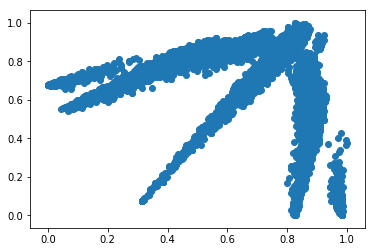

In [25]:
# Plot 2D embedding
plt.scatter(xvals[:,0],xvals[:,1])
plt.show()

In [9]:
# Create list of protein labels corresponding to embedding output and dict to link names to indices and vice versa
names = np.array(dist_df_orig.columns, dtype=int)
index_dic = dict(enumerate(names))
inverse_dic = {v: k for k, v in index_dic.items()}

In [7]:
# Create adjacency df from distance df and convert to 1D
adj_df = copy.copy(dist_df_orig)
adj_df[adj_df!=1.0] = 0
adj_mat = adj_df.values
indices = np.triu_indices_from(adj_mat,k=1)
one_d = adj_mat[indices]

In [8]:
# Calculate distances between all points
distances = scipy.spatial.distance.cdist(xvals,xvals)
one_d_dist = distances[np.triu_indices_from(distances,k=1)]

In [9]:
# Number of zero distances
print("Number of zero distances: ",len(one_d[np.nonzero(one_d_dist==0)]))

Number of zero distances:  19787


In [10]:
# Calculate metrics (threshold independent)
inv_one_d_dist = 1/one_d_dist
inv_one_d_dist[inv_one_d_dist == np.inf] = 0
print("ROC AUC: ",sklearn.metrics.roc_auc_score(one_d,inv_one_d_dist))
print("PRC AUC: ",sklearn.metrics.average_precision_score(one_d,inv_one_d_dist))

/usr/pkg/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


ROC AUC:  0.615944879706
PRC AUC:  0.004181143407


In [ ]:
# Replace distances with binary labels according to a threshold
one_d_thresh_ind = one_d_dist > 0.001
one_d_dist_bin = copy.copy(one_d_dist)
one_d_dist_bin[one_d_thresh_ind] = 0
one_d_dist_bin[np.invert(one_d_thresh_ind)] = 1

In [ ]:
# Calculate proportion of 1 in embedded labels
#dict(zip(np.unique(one_d_dist_bin, return_counts=True)[0],np.unique(one_d_dist_bin, return_counts=True)[1]))
print("Number of predicted interactions at this threshold: ", np.sum(one_d_dist_bin))

In [ ]:
# Calculate metrics (threshold dependent)
print("Precision: ",sklearn.metrics.precision_score(one_d,one_d_dist_bin))
print("Accuracy: ",sklearn.metrics.accuracy_score(one_d,one_d_dist_bin))
print("Matthews Corr Coeff: ",sklearn.metrics.matthews_corrcoef(one_d,one_d_dist_bin))

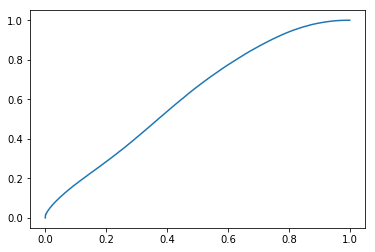

In [12]:
# Print ROCurve
roc=sklearn.metrics.roc_curve(one_d,inv_one_d_dist)
plt.plot(roc[0],roc[1])
plt.show()

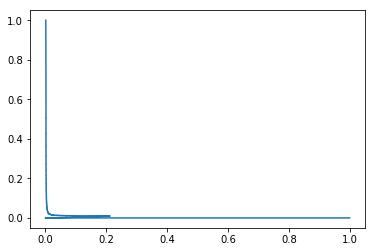

In [16]:
# Print PRCurve
prc=sklearn.metrics.precision_recall_curve(one_d,inv_one_d_dist)
plt.plot(prc[0],prc[1])
plt.show()

In [13]:
# Replace distances with binary labels according to a threshold
one_d_thresh_ind = one_d_dist > 0.1
one_d_dist_bin = copy.copy(one_d_dist)
one_d_dist_bin[one_d_thresh_ind] = 0
one_d_dist_bin[np.invert(one_d_thresh_ind)] = 1

# Calculate proportion of 1 in embedded labels
#dict(zip(np.unique(one_d_dist_bin, return_counts=True)[0],np.unique(one_d_dist_bin, return_counts=True)[1]))
print("Number of predicted interactions at this threshold: ", np.sum(one_d_dist_bin))
      
# Calculate metrics (threshold dependent)
print("Precision: ",sklearn.metrics.precision_score(one_d,one_d_dist_bin))
print("Accuracy: ",sklearn.metrics.accuracy_score(one_d,one_d_dist_bin))
print("Matthews Corr Coeff: ",sklearn.metrics.matthews_corrcoef(one_d,one_d_dist_bin))

Number of predicted interactions at this threshold:  3750938.0
Precision:  0.00435224469186
Accuracy:  0.969651250484
Matthews Corr Coeff:  0.0111861209306


In [14]:
# Replace distances with binary labels according to a threshold
one_d_thresh_ind = one_d_dist > 0.01
one_d_dist_bin = copy.copy(one_d_dist)
one_d_dist_bin[one_d_thresh_ind] = 0
one_d_dist_bin[np.invert(one_d_thresh_ind)] = 1

# Calculate proportion of 1 in embedded labels
#dict(zip(np.unique(one_d_dist_bin, return_counts=True)[0],np.unique(one_d_dist_bin, return_counts=True)[1]))
print("Number of predicted interactions at this threshold: ", np.sum(one_d_dist_bin))
      
# Calculate metrics (threshold dependent)
print("Precision: ",sklearn.metrics.precision_score(one_d,one_d_dist_bin))
print("Accuracy: ",sklearn.metrics.accuracy_score(one_d,one_d_dist_bin))
print("Matthews Corr Coeff: ",sklearn.metrics.matthews_corrcoef(one_d,one_d_dist_bin))

Number of predicted interactions at this threshold:  32133.0
Precision:  0.0689322503345
Accuracy:  0.998096844376
Matthews Corr Coeff:  0.0257694486645


In [15]:
# Replace distances with binary labels according to a threshold
one_d_thresh_ind = one_d_dist > 0.001
one_d_dist_bin = copy.copy(one_d_dist)
one_d_dist_bin[one_d_thresh_ind] = 0
one_d_dist_bin[np.invert(one_d_thresh_ind)] = 1

# Calculate proportion of 1 in embedded labels
#dict(zip(np.unique(one_d_dist_bin, return_counts=True)[0],np.unique(one_d_dist_bin, return_counts=True)[1]))
print("Number of predicted interactions at this threshold: ", np.sum(one_d_dist_bin))
      
# Calculate metrics (threshold dependent)
print("Precision: ",sklearn.metrics.precision_score(one_d,one_d_dist_bin))
print("Accuracy: ",sklearn.metrics.accuracy_score(one_d,one_d_dist_bin))
print("Matthews Corr Coeff: ",sklearn.metrics.matthews_corrcoef(one_d,one_d_dist_bin))

Number of predicted interactions at this threshold:  20694.0
Precision:  0.000869817338359
Accuracy:  0.998151144496
Matthews Corr Coeff:  -0.000252117767777


In [6]:
np.save('4Dcoordinates.npy', xvals)

In [11]:
np.save('names.npy', names)

In [4]:
np.save('G.npy', G)
np.save('N.npy', N)
np.save('p.npy', p)
np.save('df.npy', df)
print("DONE")

DONE
